# Report Visualizations

### Imports and data loading

In [4]:
%load_ext autoreload
%autoreload 2

In [81]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

In [6]:
from preprocess.vizualisation import *
from eda.report import *

2025-07-06 15:32:08.890347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751783529.051071    1321 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751783529.095792    1321 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-06 15:32:09.552132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code'

In [11]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

timestamp = "04242025"
motion_version = "versionB"
pose_version = "versionB"
preprocess_version = "v4"

metadata = pd.read_csv(path_to_root + f"data/preprocessed/landmarks_metadata_{preprocess_version}.csv")
metadata.head()


,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
0,ajudar_ne_1.mp4,ajudar_ne_1.mp4,ajudar,ajudar,False,ne,12.00000,44,3.666667,7,36,30,2.500000,v4,0.147576,0.333421,0.292776,7,6
1,ajudar_sb_2.mp4,ajudar_sb_2.mp4,ajudar,ajudar,False,sb,29.97003,79,2.635967,6,66,61,2.035367,v4,0.086359,0.206200,0.216821,0,0
2,ajudar_uf_3.mp4,ajudar_uf_3.mp4,ajudar,ajudar,False,uf,29.97003,115,3.837167,24,89,66,2.202200,v4,0.090604,0.205890,0.222293,0,0
3,ajudar_vl_4.mp4,ajudar_vl_4.mp4,ajudar,ajudar,False,vl,29.97003,141,4.704700,11,126,116,3.870533,v4,0.100236,0.210215,0.240169,25,9
4,ajudar_vl_5.mp4,ajudar_vl_5.mp4,ajudar,ajudar,False,vl,29.97000,108,3.603604,0,106,107,3.570237,v4,0.114839,0.243479,0.246769,13,12


In [ ]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [ ]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "preprocessed", 
        "landmarks",
        preprocess_version,
        "individual_metadata",
        fn.replace("mp4", "json")
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [ ]:
analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)

# Dataset

In [265]:
color_dict = {
    'ne': 'dodgerblue',       # i
    'sb': 'mediumorchid',     # s
    'uf': 'darkorange',     # u
    'vl': 'mediumseagreen',      # v
}
color_list = ['dodgerblue', 'mediumorchid', 'darkorange', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']
color_list_rgb = [colors.to_rgb(color) for color in color_list]
color_list_rgb_int = [(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in color_list_rgb]
data_source_list = ['INES', 'SignBank', 'UFV', 'V-Librasil', 'V-Librasil', 'V-Librasil']

### Final Dataset

Example of each video for a word

In [2]:
word = 'banana'

In [17]:
word_metadata = metadata[metadata['label'] == word]
word_metadata

,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
24,banana_ne_1.mp4,banana_ne_1.mp4,banana,banana,False,ne,12.00000,51,4.250000,7,37,31,2.583333,v4,0.146253,0.335704,0.289209,9,10
25,banana_sb_2.mp4,banana_sb_2.mp4,banana,banana,False,sb,29.97003,71,2.369033,3,66,64,2.135467,v4,0.085460,0.204035,0.210855,0,1
26,banana_uf_3.mp4,banana_uf_3.mp4,banana,banana,False,uf,29.97003,246,8.208200,12,209,198,6.606600,v4,0.076263,0.174447,0.194980,3,0
27,banana_vl_4.mp4,banana_vl_4.mp4,banana,banana,False,vl,29.97000,168,5.605606,1,143,143,4.771438,v4,0.103197,0.236290,0.247538,1,16
28,banana_vl_5.mp4,banana_vl_5.mp4,banana,banana,False,vl,59.94006,378,6.306300,20,289,270,4.504500,v4,0.132493,0.285565,0.289806,0,1
29,banana_vl_6.mp4,banana_vl_6.mp4,banana,banana,False,vl,59.94006,355,5.922583,2,349,348,5.805800,v4,0.125241,0.284814,0.286766,12,16


In [20]:
ne1_path, sb2_path, uf3_path, vl4_path, vl5_path, vl6_path = [os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn) for fn in word_metadata['filename']]
ne1_path, sb2_path, uf3_path, vl4_path, vl5_path, vl6_path

('/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_ne_1.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_sb_2.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_uf_3.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_4.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_5.mp4',
 '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_6.mp4')

In [24]:
ne1_frame, sb2_frame, uf3_frame, vl4_frame, vl5_frame, vl6_frame = [get_frame(1, path) for path in [ne1_path, sb2_path, uf3_path, vl4_path, vl5_path, vl6_path]]
frames = [ne1_frame, sb2_frame, uf3_frame, vl4_frame, vl5_frame, vl6_frame]

In [48]:
[(frame.shape[0],frame.shape[1]) for frame in frames]

[(176, 240),
 (1080, 1920),
 (1080, 1920),
 (1080, 1920),
 (720, 1280),
 (1080, 1920)]

In [51]:
1920/1080, 1280/720, 240/176

(1.7777777777777777, 1.7777777777777777, 1.3636363636363635)

In [60]:
313/176

1.7784090909090908

In [58]:
240/135

1.7777777777777777

In [263]:
def all_signs_for_word(frames):
    """
    Concatenate all frames for a word.
    """
    font = cv2.FONT_HERSHEY_TRIPLEX

    # find the largest frame
    max_area_index = np.argmax([frame.shape[0] * frame.shape[1] for frame in frames])
    max_area_frame = frames[max_area_index]
    target_height = max_area_frame.shape[0]
    target_width = max_area_frame.shape[1]
    target_aspect_ratio = target_width / target_height
    # pad frames to the target aspect ratio
    final_frames = []
    for i, frame in enumerate(frames):
        aspect_ratio = frame.shape[1] / frame.shape[0]

        if aspect_ratio < target_aspect_ratio:
            padded_width = int(frame.shape[0] * target_aspect_ratio)
            padding_width = (padded_width - frame.shape[1]) // 2
            padded_frame = cv2.copyMakeBorder(frame, 0, 0, padding_width, padding_width, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        else:
            padded_frame = frame.copy()

        resized_frame = cv2.resize(padded_frame, (target_width, target_height))
        color = color_list_rgb_int[i]
        bordered_frame = cv2.copyMakeBorder(resized_frame, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=color)
        
        annotated_frame = cv2.copyMakeBorder(bordered_frame, 0, 300, 0, 0, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        data_source = data_source_list[i]
        font_size = 6
        font_thickness = 5
        textsize = cv2.getTextSize(data_source, font, font_size, font_thickness)[0]
        text_x = (target_width - textsize[0]) // 2
        annotated_frame = cv2.putText(annotated_frame, data_source, (text_x, 1400), font, font_size, (0, 0, 0), font_thickness)

        final_frames.append(annotated_frame)

        if i < len(frames) - 1:
            gap = np.full((target_height + 400, 250, 3), 255, dtype=np.uint8)
            final_frames.append(gap)

    print([frame.shape for frame in final_frames])
    # concatenate the frames
    new_frame = np.concatenate(final_frames, axis=1)
    new_frame = cv2.copyMakeBorder(new_frame, 600, 100, 300, 300, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    word = "'banana'"
    font_size = 10
    font_thickness = 15
    textsize = cv2.getTextSize(word, font, font_size, font_thickness)[0]
    text_x = (new_frame.shape[1] - textsize[0]) // 2
    new_frame = cv2.putText(new_frame, word, (text_x, 400), font, font_size, (0, 0, 0), font_thickness)

    return new_frame

[(1480, 2020, 3), (1480, 250, 3), (1480, 2020, 3), (1480, 250, 3), (1480, 2020, 3), (1480, 250, 3), (1480, 2020, 3), (1480, 250, 3), (1480, 2020, 3), (1480, 250, 3), (1480, 2020, 3)]


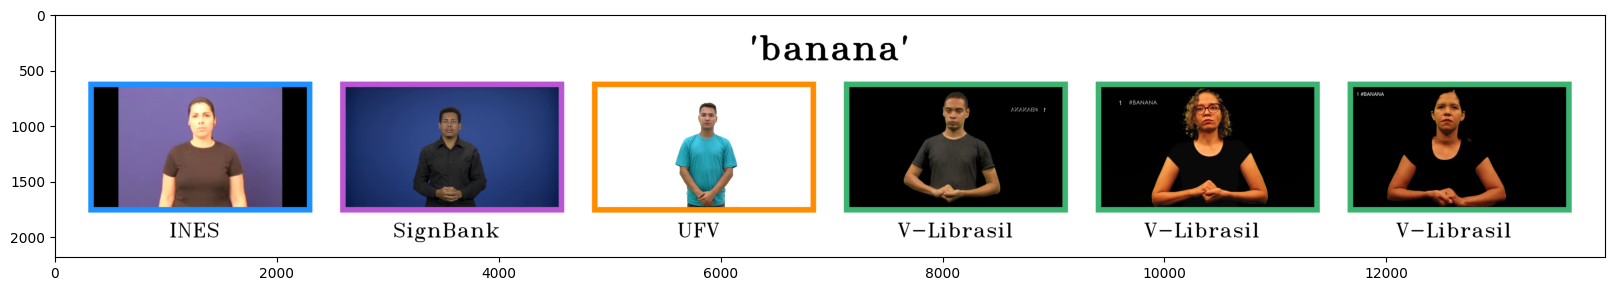

In [264]:
new_frame = all_signs_for_word(frames)
plt.figure(figsize=(20, 10))
plt.imshow(new_frame)
# plt.axis('off')

In [267]:
cv2.imwrite('new_frame.png', cv2.cvtColor(new_frame, cv2.COLOR_BGR2RGB))

True

### Dimensions & FPS

### Durations

# Preprocessing

### Pose - MediaPipe

### Motion Detection Measurement Methods

### Motion Start & End Frame Methods

### Scaling & Alignment

### Interpolation

### Summary

# Modelling

### Train / Test Split

### Frame Sampling

### Cross Validation Split (StratifiedGroupKFold)

### Data Augmentation